# Setup package dependencies

In [1]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import random
from pathlib import Path
import librosa

import numpy as np 
np.set_printoptions(precision=3)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["toolbar"] = "None"  
plt.rcParams["axes.titlesize"] = 10

import tensorflow as tf
import tensorflow.keras as tfk
# tf.compat.v1.enable_eager_execution()
%load_ext tensorboard
import datetime

from sklearn.utils import shuffle
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import get_spectrogram, plot_spectrogram, plot_eval

#### Assure repeatability


In [2]:
import os

random_seed = 42
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(random_seed)
random.seed(random_seed)
tfk.utils.set_random_seed(random_seed)

# E.D.A


#### Get some audio examples of each class


In [3]:
labels = []
data_dir = Path("DATA")
for subdir in data_dir.iterdir():
    if subdir.is_dir():
        labels.append(subdir.name)
label_names = labels
print(f"Labels: {labels}")

Labels: ['GUNS', 'ENV']


In [4]:
ex_data = []
ex_label = []
Nex = 10
for item in data_dir.glob("ENV/*.wav"):
    sr_in0 = librosa.get_samplerate(str(item))
    data, sr_in = librosa.load(str(item), sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("ENV")
    if len(ex_data) == Nex:
        break
for item in data_dir.glob("GUNS/*.wav"):
    data, sr_in = librosa.load(str(item), mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("GUNS")
    if len(ex_data) == Nex:
        break

In [5]:
from IPython.display import Audio

print("Label:", ex_label[0])
print("Waveform shape:", ex_data[0].shape)
print("Audio playback")
Audio(ex_data[0], rate=16000)

Label: ENV
Waveform shape: (4096,)
Audio playback


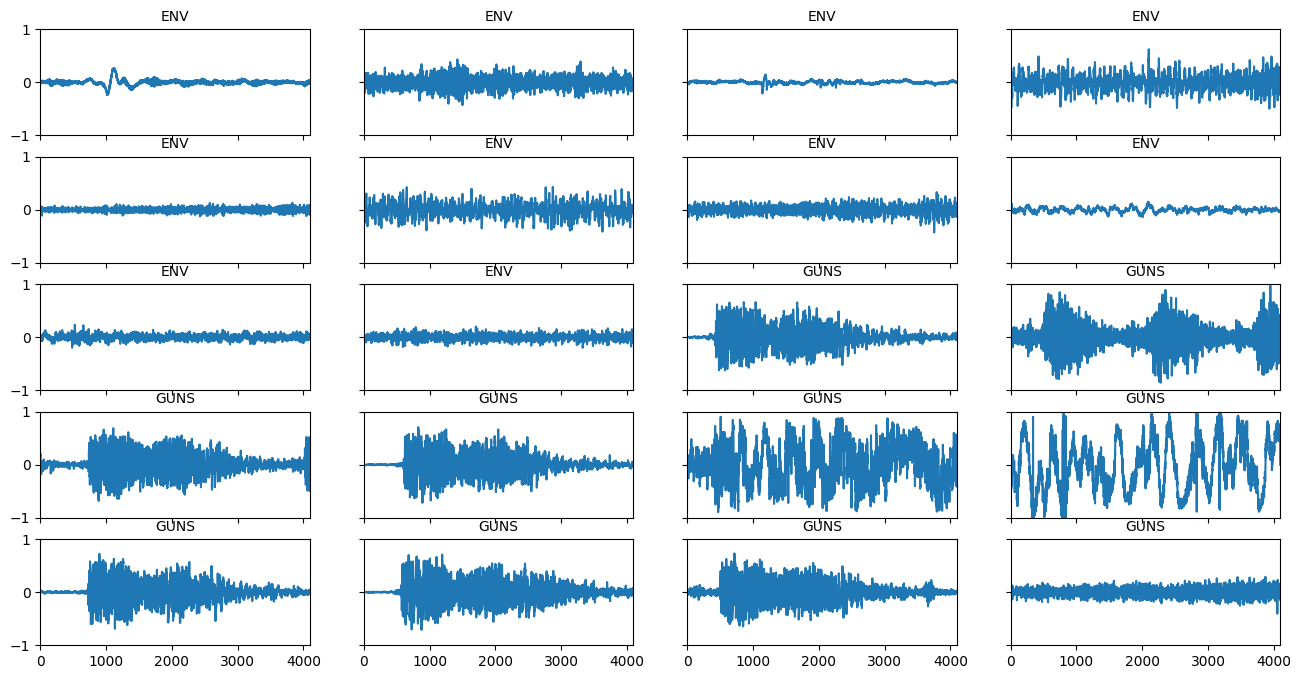

In [6]:
rows = 5
cols = 4
fig, ax = plt.subplots(
    nrows=rows, ncols=cols, figsize=(16, 8), sharex="all", sharey="all"
)
n = rows * cols
for i in range(n):
    ix = i
    plt.subplot(rows, cols, i + 1)
    plt.plot(ex_data[ix])
    plt.title(ex_label[ix])
    plt.ylim([-1, 1])

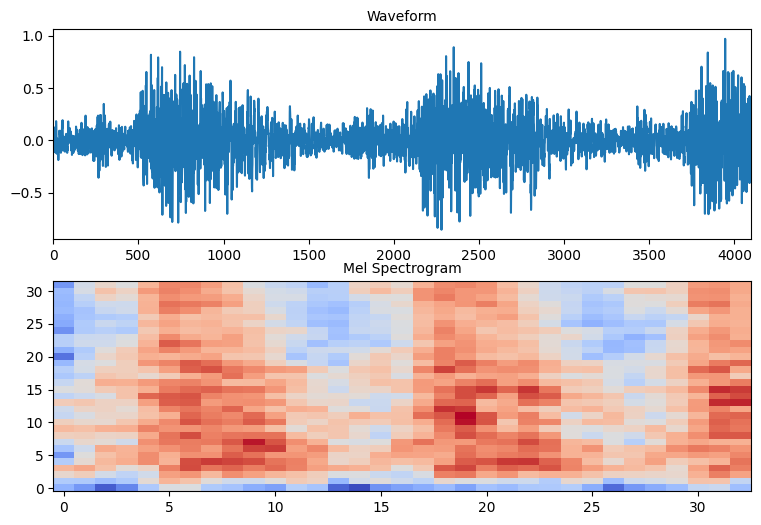

In [7]:
fig, ax = plt.subplots(2, figsize=(9, 6))
ax[0].plot(ex_data[11])
ax[0].set_title("Waveform")
Smel = get_spectrogram(ex_data[11])
plot_spectrogram(Smel, ax[1])
ax[1].set_title("Mel Spectrogram")
plt.show()

In [8]:
Imean = np.mean(Smel)
Imax = np.max(Smel)
Imin = np.min(Smel)
Istd = np.std(Smel)
print(f"Max:  {Imax} \nMin:  {Imin} \nMean: {Imean} \nStd:  {Istd}")

Max:  -10.460826873779297 
Min:  -46.85563659667969 
Mean: -24.49146270751953 
Std:  6.31412410736084


## Generate dataset


#### Feature functions - Mel Spectrogram

In [9]:
# Feature extraction - Mel spectrogram:
def get_feature_mel(fname):
    sr_in0 = librosa.get_samplerate(fname)
    data, sr_in = librosa.load(fname, sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    S = get_spectrogram(data)
    # print(f"{np.max(S)}")
    return S


# Augmentation
def augment_mel(X, y):
    X_out = []
    y_out = []
    for i in range(X.shape[0]):
        # Augment probability 35%
        if np.random.randint(100) < 35:
            x = X[i].copy()
            r, c = x.shape
            offs = random.randint(0, 10)
            # Randomly select a section of the mel spectrogram to be attenuated [in dB]
            match np.random.randint(0, 12):
                # White noise
                case 0 | 1 | 2 | 3:
                    w = np.random.uniform(low=0.66, high=0.99, size=x.shape)
                    x = np.multiply(x, w)
                # Highpass filter
                case 4:
                    x[0, :] -= 6
                    x[1, :] -= 3
                # Lowpass filter
                case 5:
                    x[r - 1, :] -= 6
                    x[r - 2, :] -= 3
                # Time patch 1
                case 6:
                    x[:, 10 + offs] -= 12
                    x[:, 11 + offs] -= 24
                    x[:, 12 + offs] -= 12
                # Time patch 2
                case 7:
                    x[:, 7 + offs] -= 12
                    x[:, 15 + offs] -= 12
                    x[:, 20 + offs] -= 12
                # Frequency patch 1
                case 8:
                    x[4 + offs] = -24
                    x[5 + offs] = -22
                    x[6 + offs] = -24
                # Frequency patch 2
                case 9:
                    x[7 + offs] = -24
                # Frequency patch 3
                case 10:
                    x[11 + offs] = -24
                # Frequency patch 4
                case 11:
                    x[15 + offs] = -24

            X_out.append(x)
            y_out.append(y[i])
    return np.array(X_out), np.array(y_out)

#### Prepare dataset

In [10]:
X = []
y = []
grp = []
for item in data_dir.glob("*/*.wav"):
    # One hot encoding based on label name from dir structure
    t = np.zeros(len(labels), dtype=int)
    t[labels.index(item.parts[-2])] = 1

    # Get feature
    feat = get_feature_mel(str(item))
    X.append(feat)
    y.append(t)
    grp.append(item.stem)

X = np.array(X)
y = np.array(y)
grp = np.array(grp)

# Shuffle data
X, y, grp = shuffle(X, y, grp)

# Split: 80 -10 - 10%
Ntot = X.shape[0]
Ntrain = int(0.8 * Ntot)
Ntest = int(0.1 * Ntot)
Nval = Ntot - Ntrain - Ntest

X_train = X[:Ntrain]
y_train = y[:Ntrain]

X_val = X[Ntrain : Ntot - Ntest]
y_val = y[Ntrain : Ntot - Ntest]

X_test = X[Ntot - Ntest :]
y_test = y[Ntot - Ntest :]

print(f"Total samples: {y.shape[0]}")
print(f"Train samples: {y_train.shape[0]}")
print(f"Val samples: {y_val.shape[0]}")
print(f"Test samples: {y_test.shape[0]}")

# Convert to Dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Total samples: 7622
Train samples: 6097
Val samples: 763
Test samples: 762


In [11]:
test_ds.save("test_data")

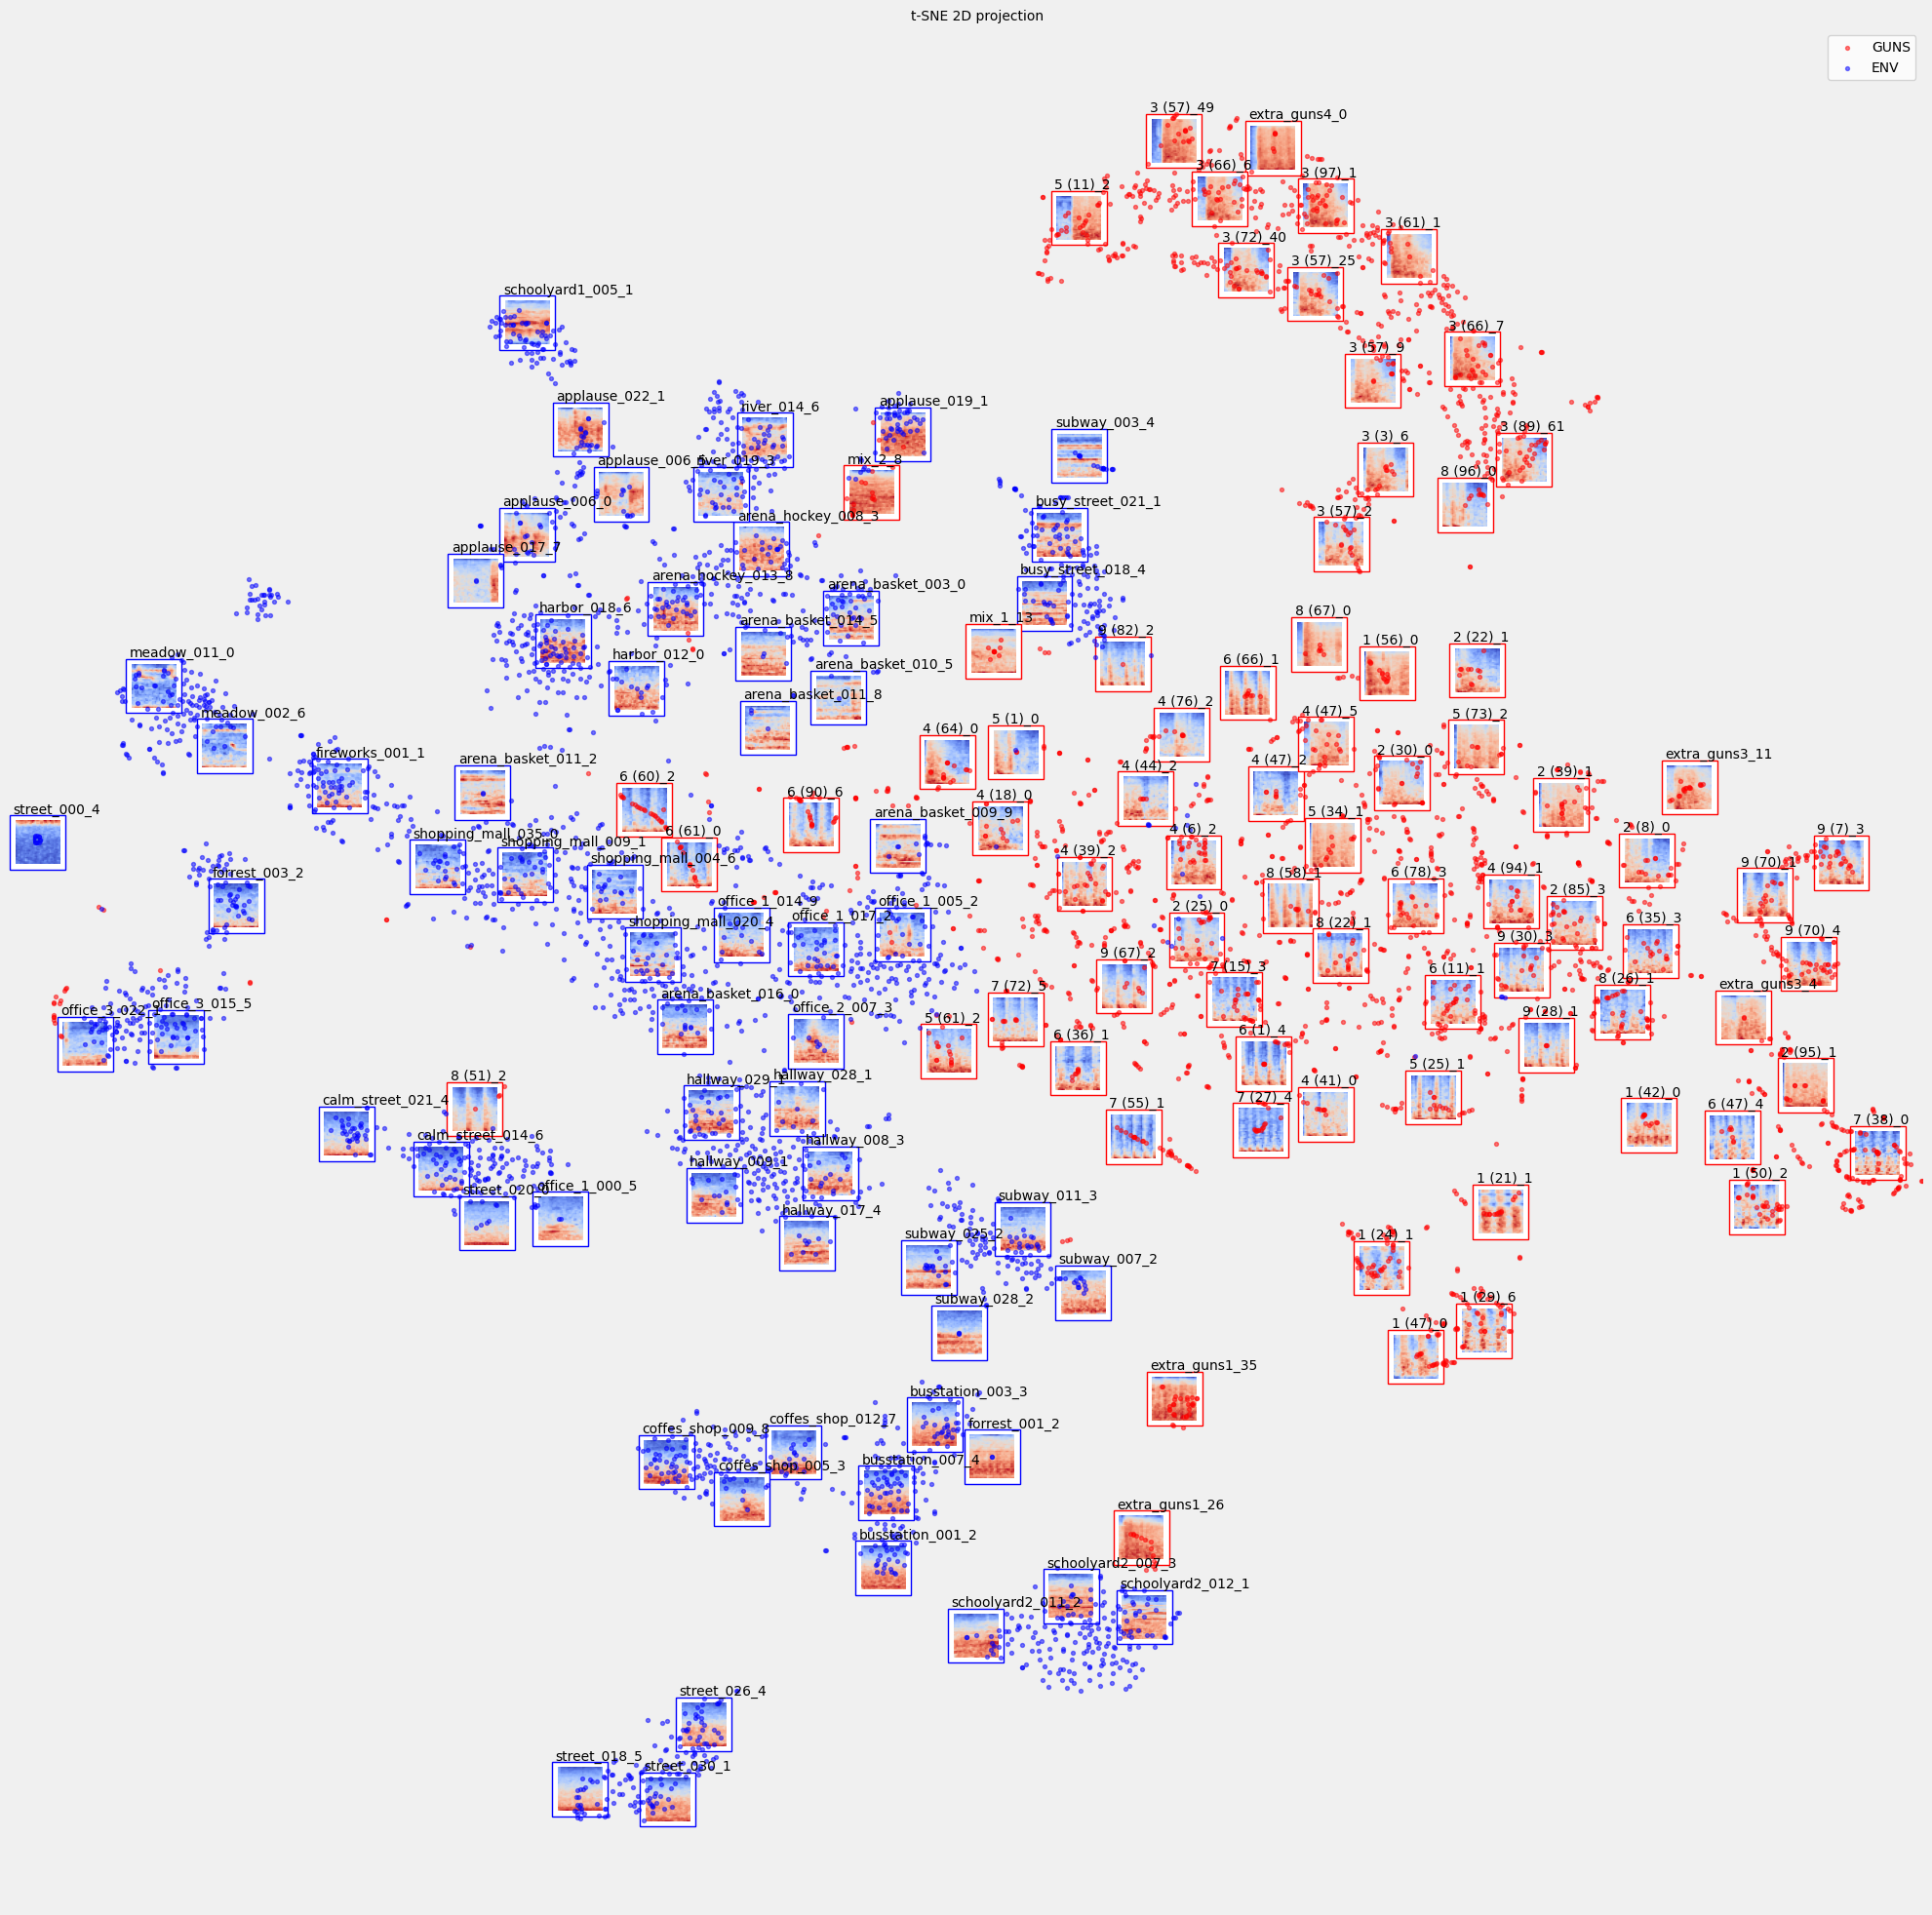

In [12]:
# Make a tSNE embedding to 2D and visualize
from sklearn.manifold import TSNE
from matplotlib import offsetbox

N = 6000

# tSNE
tsne = TSNE(n_components=2, init="pca", random_state=0, perplexity=30, max_iter=2000)
y_tsne = np.argmax(y[:N], axis=1)
x_tsne = tsne.fit_transform(X[:N].reshape(N, -1))

grp_colors = ["red", "blue"]

fig, ax = plt.subplots(1, figsize=(7, 7), facecolor="#f0f0f0")
ax.scatter(
    x_tsne[y_tsne == 0, 0],
    x_tsne[y_tsne == 0, 1],
    s=8,
    c=grp_colors[0],
    alpha=0.5,
    label="GUNS",
)
ax.scatter(
    x_tsne[y_tsne == 1, 0],
    x_tsne[y_tsne == 1, 1],
    s=8,
    c=grp_colors[1],
    alpha=0.5,
    label="ENV",
)

show_features = True
# show_features = False

if show_features:
    fig.set_figwidth(25)
    fig.set_figheight(25)
    shown_images = np.array([[1.0, 1.0]])

    for i in range(750):
        dist = np.sum((x_tsne[i] - shown_images) ** 2, 1)
        if np.min(dist) < 50:
            # don't show images that are too close
            continue
        shown_images = np.concatenate([shown_images, [x_tsne[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(X[i], cmap="coolwarm", origin="lower"),
            x_tsne[i],
            bboxprops=dict(ec=grp_colors[y_tsne[i]]),
        )
        imagebox.set(zorder=0)
        ax.add_artist(imagebox)
        ax.annotate(grp[i], x_tsne[i], xytext=(-25, 30), textcoords="offset pixels")

plt.legend()
plt.axis("off")
plt.title("t-SNE 2D projection")
plt.show()

#### Augmentation

Adding augmented samples:  2044
New total traning samples: 8141


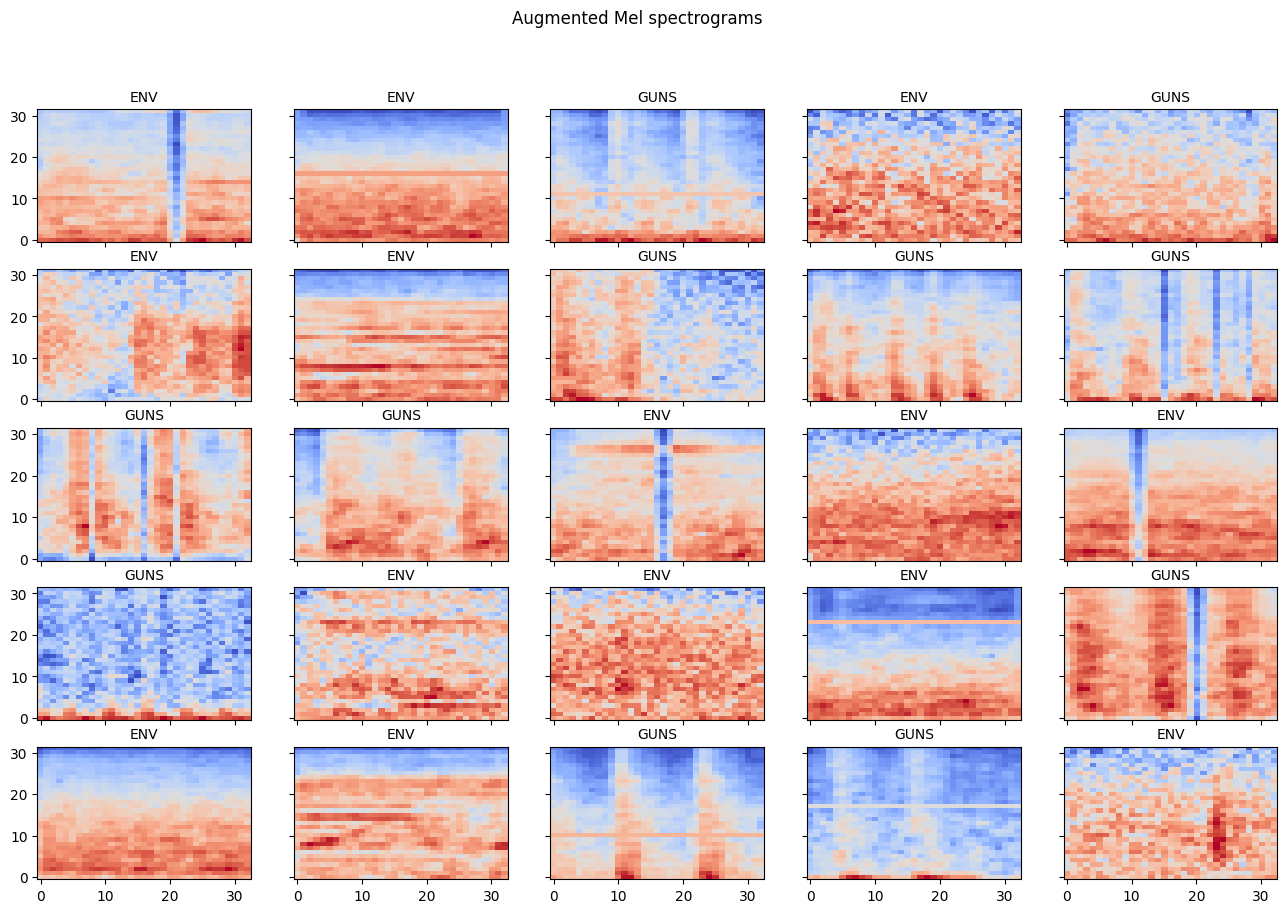

In [13]:
# Augment training data
X_aug, y_aug = augment_mel(X_train, y_train)

X_train = np.concatenate((X_aug, X_train), axis=0)
y_train = np.concatenate((y_aug, y_train), axis=0)

print(f"Adding augmented samples:  {y_aug.shape[0]}")
print(f"New total traning samples: {y_train.shape[0]}")

# Plot some examples
X_train, y_train = shuffle(X_train, y_train)
rows = 5
cols = 5
i = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharex="all", sharey="all")

aa = zip(X_aug[:25], y_aug[:25])
for xx, yy in aa:
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    i = i + 1
    plot_spectrogram(xx, ax)
    ax.set_title(label_names[np.argmax(yy)])
plt.suptitle("Augmented Mel spectrograms")
plt.show()

#### Data balance

Text(0.5, 1.0, 'Training dataset balance')

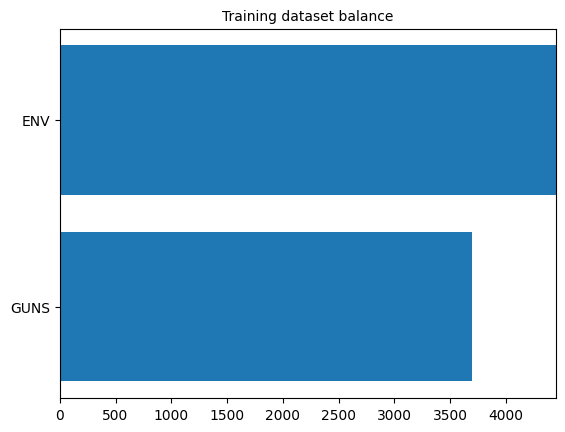

In [14]:
plt.barh(["GUNS", "ENV"], y_train.sum(axis=0))
plt.title("Training dataset balance")

#### Convert to dataset

In [15]:
# Convert to Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_ds = train_ds.cache().shuffle(35000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


# Expand dimension - channel
def exp_ds_dim(data, label):
    data = data[..., tf.newaxis]
    return data, label


train_ds = train_ds.map(exp_ds_dim).batch(16, drop_remainder=True)
val_ds = val_ds.map(exp_ds_dim).batch(16, drop_remainder=True)
test_ds = test_ds.map(exp_ds_dim).batch(16, drop_remainder=True)

## Fully Convolutional Neural network

#### Create model

Input shape: (32, 33, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 31, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 2)        │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,850 (620.51 KB)

 Trainable params: 158,850 (620.51 KB)

 Non-trainable params: 0 (0.00 B)

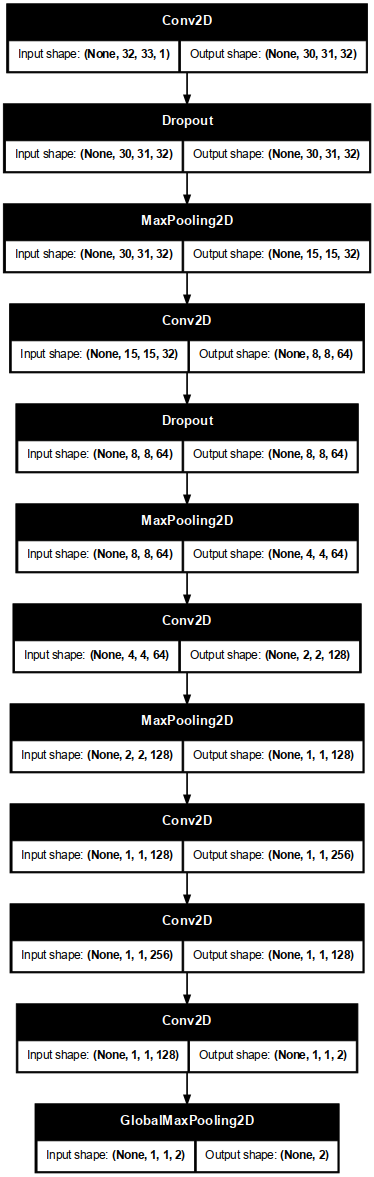

In [16]:
input_shape = next(iter(train_ds))[0].shape[1:]
print("Input shape:", input_shape)
num_labels = len(label_names)

# Use a Fully Convolutional Network to enable variable length of audio input -> output stride = 16
model_fcn = tfk.models.Sequential(
    [
        tfk.layers.Input(shape=input_shape),
        tfk.layers.Conv2D(32, 3, activation="leaky_relu", padding="valid"),
        tfk.layers.Dropout(0.2),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(
            64, 3, strides=(2, 2), activation="leaky_relu", padding="same"
        ),
        tfk.layers.Dropout(0.1),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(
            128, 3, strides=(1, 1), activation="leaky_relu", padding="valid"
        ),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(256, 1, activation="leaky_relu"),
        tfk.layers.Conv2D(128, 1, activation="leaky_relu"),
        tfk.layers.Conv2D(num_labels, (1, 1), activation="sigmoid"),
        tfk.layers.GlobalMaxPooling2D(),
    ]
)
model_fcn.summary()
dot_img_file = "DOC/model_fcn.png"
tfk.utils.plot_model(model_fcn, to_file=dot_img_file, show_shapes=True, dpi=60)

#### Define training callbacks

In [17]:
# Setup Tensorboard
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Use adaptive learning rate
def lr_schedule(epoch):
    if epoch > 20:
        return 0.00002
    if epoch > 13:
        return 0.00005
    elif epoch > 2:
        return 0.0002
    else:
        return 0.00002  # Warmup

learnRate_cb = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Use Early stop - with restore to best
earlyStop_cb = tfk.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

callbacks = [learnRate_cb, earlyStop_cb,tensorboard_callback]

#### Compile and train

Epoch 1/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.6967 - false_negatives: 1203.7859 - false_positives: 1033.6110 - loss: 0.5943 - precision: 0.7047 - recall: 0.6784 - true_negatives: 3046.3577 - true_positives: 2876.1826 - val_categorical_accuracy: 0.8923 - val_false_negatives: 77.0000 - val_false_positives: 90.0000 - val_loss: 0.4673 - val_precision: 0.8824 - val_recall: 0.8976 - val_true_negatives: 662.0000 - val_true_positives: 675.0000 - learning_rate: 2.0000e-05
Epoch 2/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - categorical_accuracy: 0.8893 - false_negatives: 443.5501 - false_positives: 432.8625 - loss: 0.4478 - precision: 0.8903 - recall: 0.8874 - true_negatives: 3647.1062 - true_positives: 3636.4185 - val_categorical_accuracy: 0.8843 - val_false_negatives: 84.0000 - val_false_positives: 88.0000 - val_loss: 0.4296 - val_precision: 0.8836 - val_recall: 0.8883 - val_true_negatives: 664.0000 - val_true_positives: 668.0000 - learning_rate: 2.0000e-05


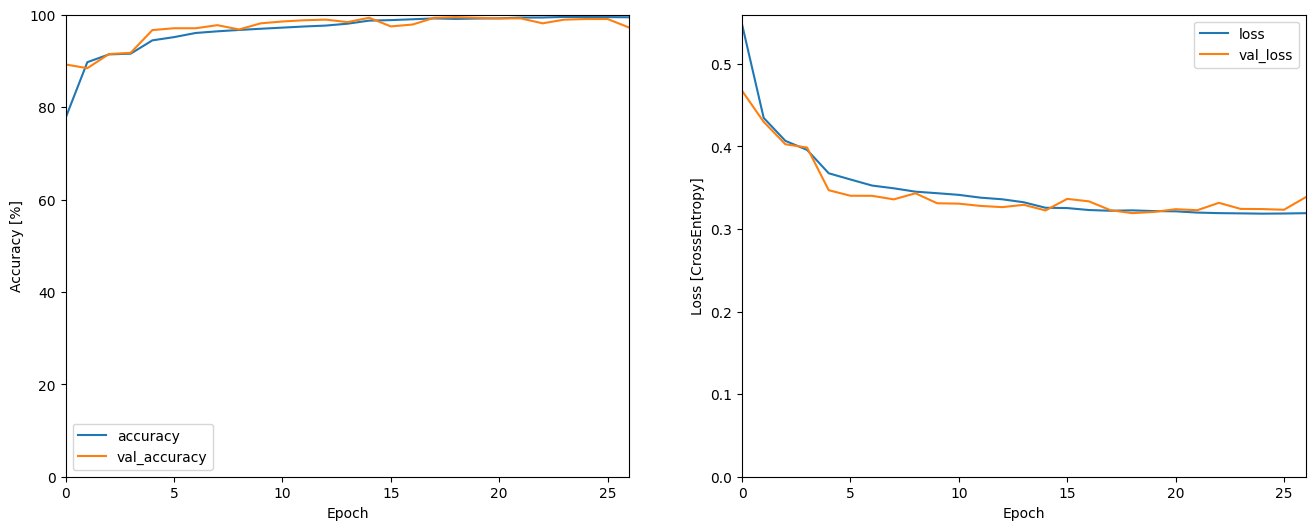

In [18]:
EPOCHS = 50
model_fcn.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        # "accuracy",
        tfk.metrics.CategoricalAccuracy(),
        tfk.metrics.FalseNegatives(),
        tfk.metrics.TrueNegatives(),
        tfk.metrics.FalsePositives(),
        tfk.metrics.TruePositives(),
        tfk.metrics.Precision(),
        tfk.metrics.Recall(),
    ],
)
history = model_fcn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

plot_eval(history)

a = model_fcn.evaluate(test_ds, return_dict=True)
print(
    f"Accuracy: {100*a['categorical_accuracy']:0.2f}% \U0001f44d \nLoss:     {a['loss']:0.4f}"
)

# Start Tensorboard here or from command line
# %tensorboard --logdir logs/fit

#### Analyse result

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


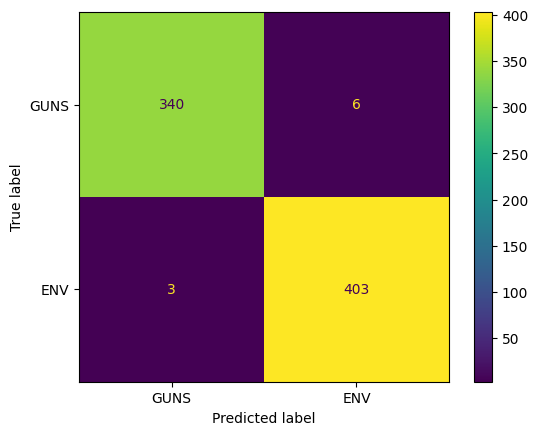

In [19]:
y_pred = model_fcn.predict(test_ds)
cm_fcn = confusion_matrix(
    np.argmax(y_test[: y_pred.shape[0], :], axis=1), np.argmax(y_pred, axis=1)
)
_ = ConfusionMatrixDisplay(cm_fcn, display_labels=labels).plot()

#### Export model

In [20]:
# Save model
import pickle

with open("GunSound_FCN.pkl", "wb") as f:
    pickle.dump(model_fcn, f)

# Random Forest Tree

#### Create pipeline

In [21]:
# Create a wrapper for a generic estimator for easier parameter tuning
from sklearn.base import BaseEstimator


class MyEstimator(BaseEstimator):

    def __init__(self, classifier=None):
        self.classifier = classifier

    def fit(self, X, y=None, **kwargs):
        self.classifier.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier.predict(X)

    def predict_proba(self, X):
        return self.classifier.predict_proba(X)

    def score(self, X, y):
        return self.classifier.score(X, y)


full_pipeline = Pipeline(
    steps=[("preScaler", "passthrough"), ("myModel", MyEstimator())]
)

full_pipeline.get_params()

{'memory': None,
 'steps': [('preScaler', 'passthrough'), ('myModel', MyEstimator())],
 'transform_input': None,
 'verbose': False,
 'preScaler': 'passthrough',
 'myModel': MyEstimator(),
 'myModel__classifier': None}

#### Setup parameter tuning

In [22]:
parameters = [
    {
        "myModel": [
            RandomForestClassifier(n_estimators=100),
        ],
        "myModel__max_depth": [10, 20, 30, 35],
        "myModel__min_samples_split": [5, 7, 10, 12, 15],
    },
]

# Perform grid search cross-validation with 5-folds and accuracy as scoring.
gs = GridSearchCV(full_pipeline, parameters, cv=5, scoring="accuracy", n_jobs=-1)

gs.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('preScaler', 'passthrough'),
  ('myModel', MyEstimator())],
 'estimator__transform_input': None,
 'estimator__verbose': False,
 'estimator__preScaler': 'passthrough',
 'estimator__myModel': MyEstimator(),
 'estimator__myModel__classifier': None,
 'estimator': Pipeline(steps=[('preScaler', 'passthrough'), ('myModel', MyEstimator())]),
 'n_jobs': -1,
 'param_grid': [{'myModel': [RandomForestClassifier()],
   'myModel__max_depth': [10, 20, 30, 35],
   'myModel__min_samples_split': [5, 7, 10, 12, 15]}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 0}

#### Train

In [23]:
Ntrain = 2000
X_tr = X_train.reshape(X_train.shape[0], -1)
y_tr = y_train
gs.fit(X_tr[:Ntrain], y_tr[:Ntrain])
print(f"Best params: \n\t{gs.best_params_}")
pd.DataFrame(gs.cv_results_)

Best params: 
	{'myModel': RandomForestClassifier(), 'myModel__max_depth': 30, 'myModel__min_samples_split': 7}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_myModel,param_myModel__max_depth,param_myModel__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.084188,0.379039,0.036015,0.008286,RandomForestClassifier(),10,5,"{'myModel': RandomForestClassifier(), 'myModel...",0.9625,0.9625,0.9350,0.9475,0.9700,0.9555,0.012590,3
1,7.251653,0.652989,0.033764,0.005574,RandomForestClassifier(),10,7,"{'myModel': RandomForestClassifier(), 'myModel...",0.9600,0.9625,0.9400,0.9400,0.9675,0.9540,0.011683,6
2,6.775067,0.310129,0.032488,0.006711,RandomForestClassifier(),10,10,"{'myModel': RandomForestClassifier(), 'myModel...",0.9525,0.9600,0.9275,0.9475,0.9650,0.9505,0.012981,16
3,6.701096,0.408818,0.028752,0.005900,RandomForestClassifier(),10,12,"{'myModel': RandomForestClassifier(), 'myModel...",0.9600,0.9550,0.9275,0.9450,0.9675,0.9510,0.013838,13
4,6.927622,0.277567,0.025309,0.001139,RandomForestClassifier(),10,15,"{'myModel': RandomForestClassifier(), 'myModel...",0.9600,0.9550,0.9250,0.9425,0.9675,0.9500,0.014916,17
5,7.562246,0.225189,0.031038,0.010723,RandomForestClassifier(),20,5,"{'myModel': RandomForestClassifier(), 'myModel...",0.9625,0.9675,0.9275,0.9475,0.9725,0.9555,0.016310,3
6,7.598036,0.450906,0.026746,0.002525,RandomForestClassifier(),20,7,"{'myModel': RandomForestClassifier(), 'myModel...",0.9600,0.9575,0.9325,0.9450,0.9725,0.9535,0.013657,8
7,7.014607,0.169100,0.026165,0.000679,RandomForestClassifier(),20,10,"{'myModel': RandomForestClassifier(), 'myModel...",0.9550,0.9550,0.9275,0.9400,0.9700,0.9495,0.014526,19
8,7.144607,0.193814,0.023908,0.001096,RandomForestClassifier(),20,12,"{'myModel': RandomForestClassifier(), 'myModel...",0.9600,0.9550,0.9275,0.9450,0.9700,0.9515,0.014457,11
9,7.103508,0.378444,0.024229,0.000792,RandomForestClassifier(),20,15,"{'myModel': RandomForestClassifier(), 'myModel...",0.9550,0.9575,0.9250,0.9475,0.9650,0.9500,0.013693,17


In [24]:
print(f"Best model:\n\t{gs.best_params_}")
sc = gs.best_estimator_.score(X_test.reshape(X_test.shape[0], -1), y_test)
print(f"Score:\n\t{100*sc:2.2f}%")

Best model:
	{'myModel': RandomForestClassifier(), 'myModel__max_depth': 30, 'myModel__min_samples_split': 7}
Score:
	96.98%


#### Fine tune

In [25]:
# Finetune/retrain above model on larger dataset
gs.best_estimator_.fit(X_tr, y_tr)
sc = gs.best_estimator_.score(X_test.reshape(X_test.shape[0], -1), y_test)
model = gs.best_estimator_
print(f"Score:\n\t{100*sc:2.2f}%")

Score:
	98.03%


#### Analyse result

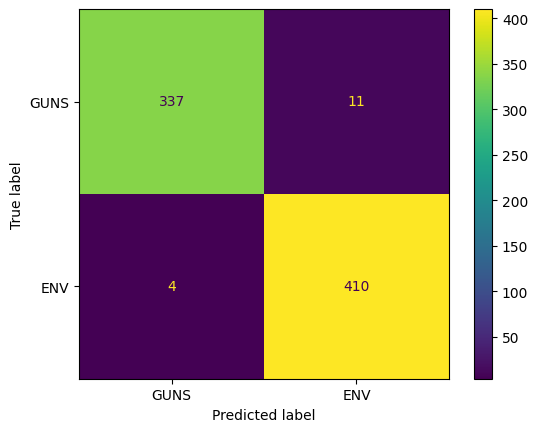

In [26]:
y_pred = gs.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))
cm_tree = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
ConfusionMatrixDisplay(cm_tree, display_labels=labels).plot()

#### Export model 

In [27]:
# Save model
import pickle

with open("GunSound_RndForest.pkl", "wb") as f:
    pickle.dump(model, f)